In [7]:
import pandas as pd
import numpy as np

# [Step 1] 원본 데이터 로드 및 복사
customer = pd.read_csv("customer_hm.csv")
transactions = pd.read_csv("transactions_hm.csv")
articles = pd.read_csv("articles_hm.csv")

# 경로에 맞게 위 아래 중 선택 주석처리
# customer = pd.read_csv('../../data/customer_hm.csv')
# transactions = pd.read_csv('../../data/transactions_hm.csv')
# articles = pd.read_csv('../../data/articles_hm.csv')

#copy
df_cust = customer.copy()
df_tran = transactions.copy()
df_art = articles.copy()

# [Customer] 데이터 전처리

#1. fashion_news_frequency가 결측치인 데이터만 추출 (결측치 Regularly로 대체)
missing_data = df_cust[df_cust['fashion_news_frequency'].isnull()]

#1-2. 결측치 'Regularly'으로 채우기
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].fillna('Regularly')

#2. 문자형 정수형으로 매핑 (사전 정의)
status_map = {'ACTIVE': 2, 'PRE-CREATE': 1, 'LEFT CLUB': 0}
frequency_map = {'Regularly': 2, 'Monthly': 1, 'NONE': 0}

#2-2.  매핑 적용
df_cust['club_member_status'] = df_cust['club_member_status'].map(status_map)
df_cust['fashion_news_frequency'] = df_cust['fashion_news_frequency'].map(frequency_map)


#3. 연령대 그룹화 (age_segment) : 나이를 나이대별로 나눠 파생변수 생성
def cate_age(age):
    if age < 20: return '10대'
    elif age < 30: return '20대'
    elif age < 40: return '30대'
    elif age < 50: return '40대'
    elif age < 60: return'50대'
    else: return '60대 이상'

df_cust['age_segment'] = df_cust['age'].apply(cate_age)


# [Transactions] 데이터 전처리

#1. join을 위해 동일한 타입으로 변환
df_tran['customer_id']= df_tran['customer_id'].astype(str)
df_cust['customer_id']= df_cust['customer_id'].astype(str)

df_tran['article_id']= df_tran['article_id'].astype(str).str.zfill(10)
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

#2. 데이터 크기 및 중복 제거
df_tran.drop_duplicates(inplace=True)

#3. 날짜 타입 변환 및 월 컬럼 생성
df_tran['t_dat'] = pd.to_datetime(df_tran['t_dat'], format='%Y-%m-%d')
df_tran['year_month'] = df_tran['t_dat'].dt.to_period('M')

#4. 판매 채널 한글 컬럼 생성 및 값 변환
df_tran["channel"] = df_tran["sales_channel_id"].map({1: "오프라인", 2: "온라인"})

df_tran["channel"].value_counts() 
numbs = df_tran["channel"].value_counts()
print("온라인:", f"{numbs['온라인']:,}")
print("오프라인:", f"{numbs['오프라인']:,}")
print("전체 거래 건수:", f"{df_tran.shape[0]:,}")

#가격 데이터 분포 확인
df_tran['price'].describe() 
print("price가 0.1 이상:", len(df_tran[df_tran["price"] >= 0.1]))
print("price가 0.2 이상:", len(df_tran[df_tran["price"] >= 0.2]))
print("price가 0.3 이상:", len(df_tran[df_tran["price"] >= 0.3]))
print("price가 0.4 이상:", len(df_tran[df_tran["price"] >= 0.4]))
print("price가 0.5 이상:", len(df_tran[df_tran["price"] >= 0.5]))

#고가 거래 분리 및 채널 확인
high_price_transactions = df_tran[df_tran["price"] >= 0.4]
high_price_transactions['sales_channel_id'].replace({1: 'Offline', 2: 'Online'}).value_counts() 

#월별 거래 건수 & 매출액 계산
monthly_sales = df_tran.groupby('year_month').size()    #행=거래량
monthly_price = df_tran.groupby('year_month')['price'].sum()    #매출액뽑기

print(monthly_price)

#최고 매출 월 
best_month = monthly_price.idxmax()
best_value = monthly_price.max()

print("가장 매출이 높은 달:", best_month)
print("그 달의 매출:", best_value) 


# [Article] 데이터 전처리: 상품 전략 파생변수 생성

#1. ID 형식 통일
df_art['article_id'] = df_art['article_id'].astype(str).str.zfill(10)

#2. 결측치(NULL) 제어 (detail_desc의 NULL값을 No Description로)
df_art['detail_desc'] = df_art['detail_desc'].fillna('No Description')

#3. 불필요 컬럼 제거 (메모리 줄이기) : Name(이름)이 존재하여 중복 정보인 Code(코드성 숫자) 컬럼 불필요
cols_to_drop = [
    'product_type_no', 
    'graphical_appearance_no', 
    'colour_group_code', 
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no'
]
df_art_cleaned = df_art.drop(columns=cols_to_drop) 

#4. 매핑 및 파생변수 설정
#4-1. 시즌 별 매핑 (product_season) / 시즌성 구분을 위한 키워드 정의
def get_season(row):
    # section_name과 prod_name을 합쳐서 판단
    text = (str(row['section_name']) + " " + str(row['prod_name'])).lower()
    group = str(row['product_group_name']).lower()
    
    # 1. SS
    ss_keywords = [
        'swimwear', 'sport', 'shorts', 'sandals', 'sleeveless', 
        'tank', 'mini', 'beach', 'summer', 'sun', 'flip flop', 
        'skirt', 'dress'
    ]

    # 2. FW 
    fw_keywords = [
        'outerwear', 'knitted', 
        'jacket', 'coat', 'hoodie', 'sweatshirt', 'scarf', 'gloves', 
        'boots', 'heavy', 'fur', 'wool', 'cardigan', 'winter'
    ]
    
    if any(kw in text for kw in ss_keywords) or group in ['swimwear']:
        return 'SS'
    # FW는 오직 두꺼운 옷 키워드가 있을 때만! (items of clothing 조건 제거)
    elif any(kw in text for kw in fw_keywords):
        return 'FW'
    else:
        return 'All-Season'

#4-2. 파생변수 생성 및 axis=1로 왼쪽에서 오른쪽으로(행 방향) 읽도록 조정
df_art_cleaned['product_season'] = df_art_cleaned.apply(get_season, axis=1)
#4-3. 메인 카테고리 정의 (원본 보존)
df_art_cleaned['category_main'] = df_art_cleaned['index_group_name'] 


#5. 저관여/고관여 제품 분류 (product_strategy)
def get_involvement_strategy(row):
    garment = str(row['garment_group_name']).lower()
    section = str(row['section_name']).lower()
    # 1. 저관여 (베이직)
    if any(kw in garment for kw in ['basic', 'underwear', 'socks', 'jersey']) or \
       'basic' in section:
        return 'Low_Involvement_Basic'
    # 2. 고관여 (전략템/트렌드템)
    elif any(kw in garment for kw in ['knitwear', 'outerwear', 'dresses']) or \
         any(kw in section for kw in ['trend', 'special']):
        return 'High_Involvement_Strategic'
    else:
        return 'General_Fashion'
    
df_art_cleaned['product_strategy'] = df_art_cleaned.apply(get_involvement_strategy, axis=1)

#6. 신상품/트렌드 키워드 추출 (is_new)
def check_newness(row):
    text = (str(row['prod_name']) + " " + str(row['detail_desc'])).lower()
    new_keywords = ['new', 'collection', 'latest', 'trend', 'exclusive']
    
    if any(kw in text for kw in new_keywords):
        return 'New_Arrival'
    return 'Regular_Carryover'

df_art_cleaned['is_new'] = df_art_cleaned.apply(check_newness, axis=1)

#7. 색상 그룹화 (color_tone)
def get_color_tone(color):
    color = str(color).lower()
    dark_colors = ['black', 'dark blue', 'dark grey', 'dark red', 'dark pink', 'dark purple', 'dark green', 'dark orange', 'dark beige', 'dark turquoise', 'dark yellow', 'grey', 'bronze/copper']
    light_colors = ['white', 'off white', 'light beige', 'light blue', 'light grey', 'light orange', 'light pink', 'light green', 'light red', 'light yellow', 'light purple', 'transparent', 'light turquoise']
    
    if any(dc in color for dc in dark_colors):
        return 'Dark_Tone'
    elif any(lc in color for lc in light_colors):
        return 'Light_Tone'
    else:
        return 'Neutral_Tone'

df_art_cleaned['color_tone'] = df_art_cleaned['colour_group_name'].apply(get_color_tone)

온라인: 721,488
오프라인: 318,613
전체 거래 건수: 1,040,101
price가 0.1 이상: 10704
price가 0.2 이상: 719
price가 0.3 이상: 126
price가 0.4 이상: 29
price가 0.5 이상: 2
year_month
2019-01    2129.926131
2019-02    1989.217641
2019-03    2374.905504
2019-04    2703.443538
2019-05    2748.199469
2019-06    3088.776976
2019-07    2552.035334
2019-08    1943.422489
2019-09    2559.226862
2019-10    2358.486793
2019-11    2463.769270
2019-12    1985.492149
Freq: M, Name: price, dtype: float64
가장 매출이 높은 달: 2019-06
그 달의 매출: 3088.776976142


In [8]:
##체크 용도
#df_cust
display(df_cust[['customer_id', 'age', 'age_segment', 'club_member_status', 'fashion_news_frequency']].head())

#df_tran
display(df_tran[['customer_id', 'article_id', 't_dat', 'year_month', 'channel', 'price']].head())

#df_art_cleaned
display(df_art_cleaned[['article_id', 'prod_name', 'product_strategy', 'is_new', 'product_season', 'color_tone']].head())

,customer_id,age,age_segment,club_member_status,fashion_news_frequency
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,49,40대,2,0
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,25,20대,2,0
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,24,20대,2,0
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,54,50대,2,0
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,52,50대,2,2


,customer_id,article_id,t_dat,year_month,channel,price
0,3e2b60b679e62fb49516105b975560082922011dd752ec...,0698328010,2019-11-05,2019-11,온라인,0.016932
1,89647ac2274f54c770aaa4b326e0eea09610c252381f37...,0760597002,2019-05-22,2019-05,온라인,0.033881
2,2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...,0488561032,2019-05-10,2019-05,온라인,0.016932
3,7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...,0682771001,2019-08-26,2019-08,온라인,0.033881
4,3b77905de8b32045f08cedb79200cdfa477e9562429a39...,0742400033,2019-08-10,2019-08,오프라인,0.003220


,article_id,prod_name,product_strategy,is_new,product_season,color_tone
0,0108775015,Strap top,Low_Involvement_Basic,Regular_Carryover,All-Season,Dark_Tone
1,0108775044,Strap top,Low_Involvement_Basic,Regular_Carryover,All-Season,Light_Tone
2,0108775051,Strap top (1),Low_Involvement_Basic,Regular_Carryover,All-Season,Light_Tone
3,0110065001,OP T-shirt (Idro),General_Fashion,Regular_Carryover,All-Season,Dark_Tone
4,0110065002,OP T-shirt (Idro),General_Fashion,Regular_Carryover,All-Season,Light_Tone


### [Data Dictionary] 

#### 1. 파생변수
- **product_strategy** : 상품 관여도 전략 (Basic / Strategic / General)
- **age_segment** : 고객 연령대 세그먼트 (10대 ~ 60대+)
- **is_new** : 신상품 반응 지표 (New_Arrival / Regular_Carryover)
- **product_season** : 상품 시즌 속성 (FW / SS / All-Season)
- **color_tone** : 디자인 톤앤매너 (Dark / Light / Neutral)

#### 2. 기본 정보 (Raw Data)
- **channel** : 온/오프라인 구매 채널 (매출 발생 지점 확인)
- **club_member_status** : 멤버십 등급 (로열티 고객의 구매 유지력 확인)
- **fashion_news_freq** : 마케팅 뉴스레터 구독 빈도 (CRM 활동 영향력 측정)
- **price** : 상품 판매 단가 (객단가 및 가격대별 수요 분석)
- **year_month** : 시간 지표 (6월 정점 대비 8월 하락세의 기준축)
- **category_main** : 여성/남성/아동 등 메인 카테고리 (품목별 성과 측정)

In [9]:
# [JOIN] df_tran 기준 Left Join
# 고객의 나이대(age_segment), 뉴스 구독 빈도 등을 거래 내역에 연결
df_merged = pd.merge(
    df_tran, 
    df_cust, 
    on='customer_id', 
    how='left'
)

# 결과 확인
# print(f"조인 후 전체 행 수: {len(df_merged)}")
# print(f"고객 정보가 매칭되지 않은 거래 건수: {df_merged['age_segment'].isnull().sum()}")
# articles 조인은 이후 필요하면 진행

print("결합 후 데이터 크기:", df_merged.shape)
print(df_merged.head())

결합 후 데이터 크기: (1040101, 13)
       t_dat                                        customer_id  article_id  \
0 2019-11-05  3e2b60b679e62fb49516105b975560082922011dd752ec...  0698328010   
1 2019-05-22  89647ac2274f54c770aaa4b326e0eea09610c252381f37...  0760597002   
2 2019-05-10  2ebe392150feb60ca89caa8eff6c08b7ef1138cd6fdc71...  0488561032   
3 2019-08-26  7b3205de4ca17a339624eb5e3086698e9984eba6b47c56...  0682771001   
4 2019-08-10  3b77905de8b32045f08cedb79200cdfa477e9562429a39...  0742400033   

      price  sales_channel_id year_month channel   FN  Active  \
0  0.016932                 2    2019-11     온라인  1.0     1.0   
1  0.033881                 2    2019-05     온라인  0.0     0.0   
2  0.016932                 2    2019-05     온라인  1.0     1.0   
3  0.033881                 2    2019-08     온라인  0.0     0.0   
4  0.003220                 1    2019-08    오프라인  0.0     0.0   

   club_member_status  fashion_news_frequency   age age_segment  
0                 2.0                    

In [10]:
# ### tran에 art left join
df_tran_art = pd.merge(
    df_tran, 
    df_art_cleaned, 
    on='article_id', 
    how='left'
)

# display(df_tran_art[['t_dat', 'prod_name', 'product_strategy', 'product_season', 'price']].head())

In [11]:
## 합쳐버려
df_final = pd.merge(
    df_merged, 
    df_art_cleaned, 
    on='article_id', 
    how='left'
)

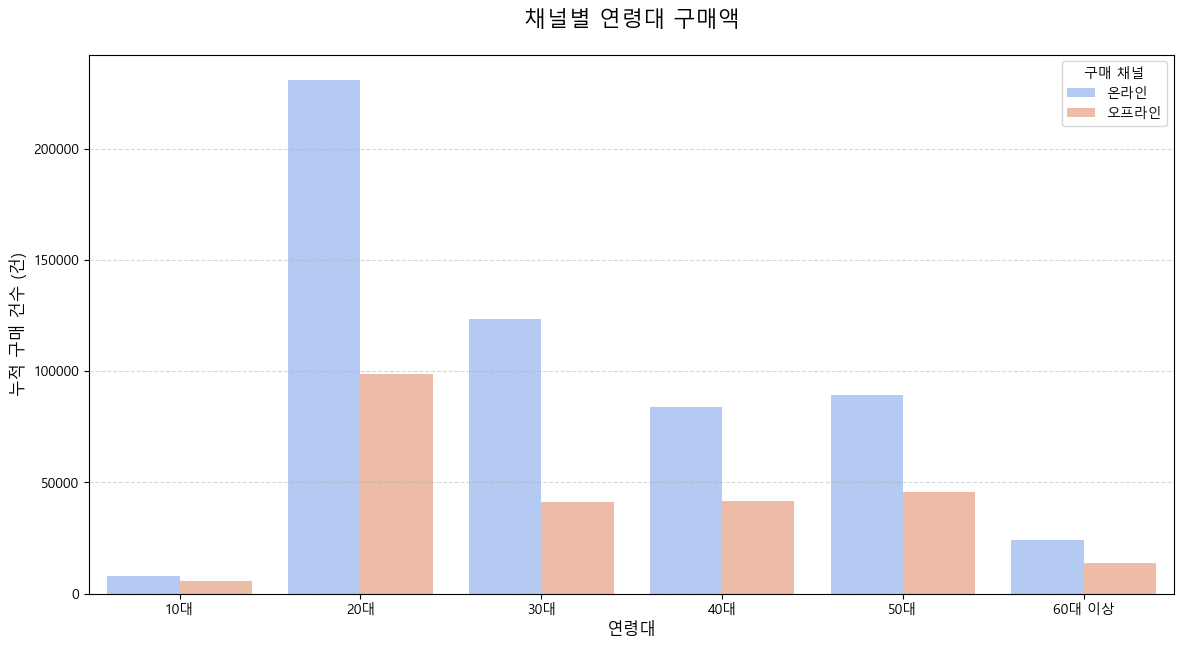

연령대별 온/오프라인 비중


channel,오프라인,온라인
age_segment,,
10대,42.14,57.86
20대,29.95,70.05
30대,25.04,74.96
40대,33.25,66.75
50대,33.88,66.12
60대 이상,35.93,64.07


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

#시각화
plt.figure(figsize=(14, 7))

#폰트 (네이놈자꾸깨지는구나)
plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

#연령대별/채널별 분포
sns.countplot(
    data=df_merged, 
    x='age_segment', 
    hue='channel', 
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상'],
    palette='coolwarm'
)

plt.title('채널별 연령대 구매액', fontsize=16, pad=20)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('누적 구매 건수 (건)', fontsize=12)  #df_merged 행의 개수(=거래 개수)
plt.legend(title='구매 채널')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

# 2. pivot - 전 기간 평균 채널 이용 비중 (%)
total_age_channel_pivot = pd.crosstab(df_merged['age_segment'], df_merged['channel'], normalize='index') * 100
# pd.crosstab는 빈도수를 구하는 pivot table
print("연령대별 온/오프라인 비중")
display(total_age_channel_pivot.round(2))

* 왜 9월 하루 히트쳤을까? 그리고 왜 직전달에 나락(;;)갔을까?
    * 예상 1. 2019 9월 AW 가 있으니 구매도가 낮아지고, AW 발표 후 급상승 (유력)
    * 예상 2. 계절과 연관이 있을 것이다(스웨덴 날씨는 온화하므로, 가을 준비(옷 구매)의 직전이라 구매도 낮음?)
    * 예상 3. 사회적인 이슈가 있었을 것이다 <- 그러나 이때 H&M은 AW 이후 지속가능한경영으로 인지도가 높아져서 아닐듯
    * -> year_month 별로 product_season? is_new? 그냥 category_main?

* 어떤 상품이 인기있을까? (계졀 별)
    * ->

* 어떤 계절에 온/오프라인 구매가 늘었을까?

* 6월의 전체 평균 구매율이 높은 이유는 수영복 때문인가? 외출이 잦기 때문? 혹은 6월 구매가 높은 제품은 사실 전체 비율의 소비품목과 다를 수 있다. 마케팅에서도 계절성이 있는 품목일 경우 한 시즌 때 폭발적으로 인기가 늘어나지만 평균으로 따지면 그다지 도드라져보이지 않는다는 특성 있음 
    * -> category_main에서 'Swimwear' 카테고리 추출할 수도 있겠다

* 20대가 온라인에서 수영복을 구매하고, 50대가 오프라인에서 아우터(혹은 선물용 아동복)를 구매한다는 가설 입증
    * -> age_segment, channel, category_main 필요

* 코호트 분석으로 온/오프라인 리텐션? 을 가장 잘 볼 수 있을듯
    * -> 첫 구매를 온/오프라인 채널로 한 고객이 얼마나 잘 돌아오는가

(추가)
* 연령대 별 선호 상품 카테고리가 정말 다를까?


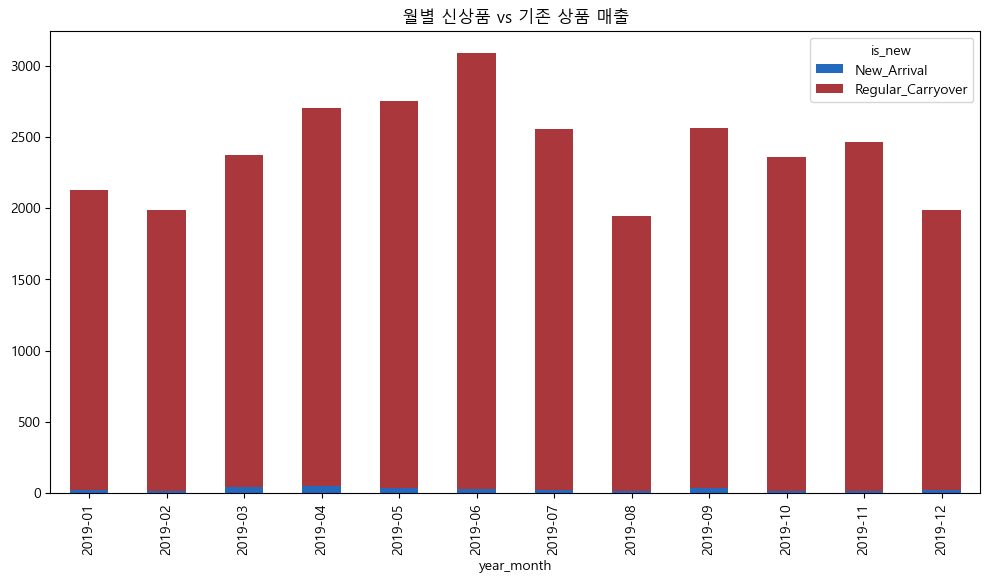

In [13]:
# 월별 신상품(New_Arrival) 매출 기여도 분석
new_trend = df_tran_art.groupby(['year_month', 'is_new'])['price'].sum().unstack()
new_trend.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='vlag')
plt.title('월별 신상품 vs 기존 상품 매출')
plt.show()

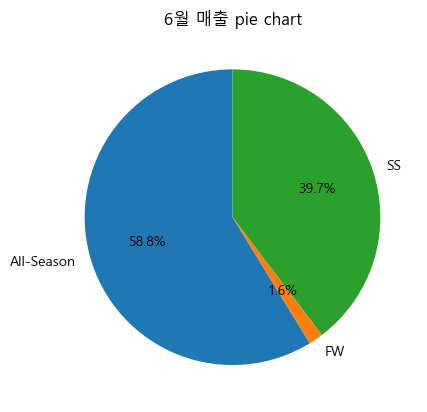

In [14]:
# 6월의 전체 평균 구매율이 높은 이유는 수영복 때문인가?
best_sales = df_tran_art[df_tran_art['year_month'] == '2019-06']
best_sales = best_sales.groupby('product_season')['price'].sum()   #'매출'단위
best_sales.plot(kind='pie', autopct='%1.1f%%', startangle=90, title='6월 매출 pie chart')
plt.show()

product_season을 더 세세하게 구분하니까 All_season 비중과 ss 비중이 꽤 비슷한 비중으로 나옴.
가장 구매도가 높았던 '날'인 9월인 FW 시즌에서는 비중이 적은 것을 보아 AW 시즌 발표랑 겹쳐서 인기를 끌었던 것 같음. 딱히 베스트셀러나 인기 상품이 쭉 유지되는 상황은 아니었던 것으로 보인다.

5~6월이 구매도가 가장 높았던 만큼 SS 비중이 높다.
SS에 어떤 제품들이 포함되어 있는지는 아래에서 확인해봐야겠음

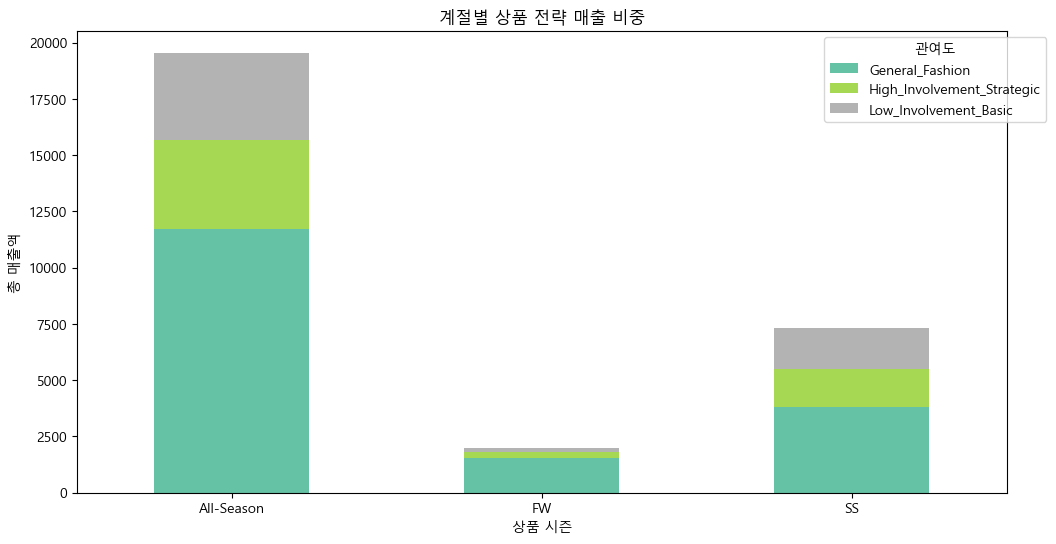

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc('font', family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

# product_season, price 합계
seasonal_strategy = df_tran_art.groupby(['product_season', 'product_strategy'])['price'].sum().unstack()

# 시각화
seasonal_strategy.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='Set2')

plt.title('계절별 상품 전략 매출 비중')
plt.ylabel('총 매출액')
plt.xlabel('상품 시즌')
plt.legend(title='관여도', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=0)
plt.show()

### 해석
* all-season이 압도적으로 많다.... 시즌 상품보다 가성비 일반 저관여 제품이 인기가 많은 것 같다
* 가격 전략이 애초에 가성비 앤드 애브리데이라서 그럴 듯 실제로 어떤 카테고리가 인기가 많을까
* 일반 제품 > 고관여 > 저관여
* 근데 일반 제품에 뭐뭐 들어가있는지 확인이 불가능해서 category_main으로 한번 다시 봐야할듯

* 일반 제품이 압도적으로 많은데 사실 분류가 키워드로 분류한 거라서 

In [16]:
### 카테고리 중 인기 품목, 시즌성 품목 중 뭐뭐 있는지 다시 파악해보기 위함

# 1. 'General_Fashion'으로 분류된 데이터만 추출
df_general = df_tran_art[df_tran_art['product_strategy'] == 'General_Fashion']

# 2. 그중에서 어떤 품목(Group)이 가장 많은지 TOP 10 확인
general_top_groups = df_general['product_group_name'].value_counts().head(10)
print("--- 일반 제품 내 상위 품목군 ---")
print(general_top_groups)

# 3. 더 구체적인 상품명(prod_name) TOP 10 확인
general_top_products = df_general['prod_name'].value_counts().head(10)
print("\n--- 일반 제품 내 상위 실제 상품명 ---")
print(general_top_products)

--- 일반 제품 내 상위 품목군 ---
product_group_name
Garment Lower body    182593
Garment Upper body    135012
Swimwear               86557
Underwear              69602
Accessories            51543
Shoes                  24973
Garment Full body      11069
Nightwear              10338
Unknown                 1209
Socks & Tights           654
Name: count, dtype: int64

--- 일반 제품 내 상위 실제 상품명 ---
prod_name
Jade HW Skinny Denim TRS       5919
Luna skinny RW                 4561
Timeless Midrise Brief         2948
Despacito                      2749
Kanta slacks RW                2574
Simple as That Triangle Top    2499
Skinny Ankle R.W Brooklyn      2437
Shake it in Balconette         2211
Simple as that Cheeky Tanga    2095
Hazelnut Push Melbourne        1934
Name: count, dtype: int64


### 일반 제품 내 상위 품목군 순위별로
- 1 : 하의(가장 높은 매출)
- 2 : 상의(안정적인 수요. 두번째로 매출 높음)
- 3 : 수영복 (6월달의 효자 품목일 가능성 매우 ↑)
- 4 : 이너웨어 (편의품(저관여, 빈도 多, 가성비))
- 5 : 액세서리 (액세서리는 시즌성이 있다고 봐야하나? 선글라스, 목도리, 귀걸이 등?)
- 6 : 신발
- 7 : 원피스, 점프수트
- 8 : 잠옷(홈웨어)
- 9 : 미분류
- 10 : 양말, 타이츠

### 일반 제품 내 상위 실제 상품명 순위별로
- 1 : 데님 팬츠
- 2 : 스키니 팬츠
- 3 : 이너웨어 하의
- 4 : 데스..파..시..또...
- 5 : 슬랙스(포멀한 정장 계열)
- 6 : 란제리 상의
- 7 : 스키니 팬츠
- 8 : 란제리 상의
- 9 : 이너웨어 하의
- 10 : 란제리 상의

In [17]:
##* 20대가 온라인에서 수영복을 구매하고, 50대가 오프라인에서 아우터(혹은 선물용 아동복)를 구매한다는 가설 입증


## -> age_segment, channel, category_main 필요
# 1 고객/거래 정보 + 상품 정보 통합되어있는지 확인
display(df_final[['age_segment', 'channel', 'product_group_name', 'price']].head())

### 해석 : high_price_transactions의 기준이 0.4
# [0] : 0.0169	매우 저렴한 상품 (0.4의 약 1/24 수준)
# [1] : 0.0338	일반적인 상품 (티셔츠 등 기본 아이템 추정)
# [4] : 0.0032	최저가 소모품 (미끼 상품 혹은 번들 제품)

,age_segment,channel,product_group_name,price
0,50대,온라인,Garment Upper body,0.016932
1,20대,온라인,Garment Upper body,0.033881
2,30대,온라인,Garment Lower body,0.016932
3,10대,온라인,Accessories,0.033881
4,30대,오프라인,Socks & Tights,0.003220


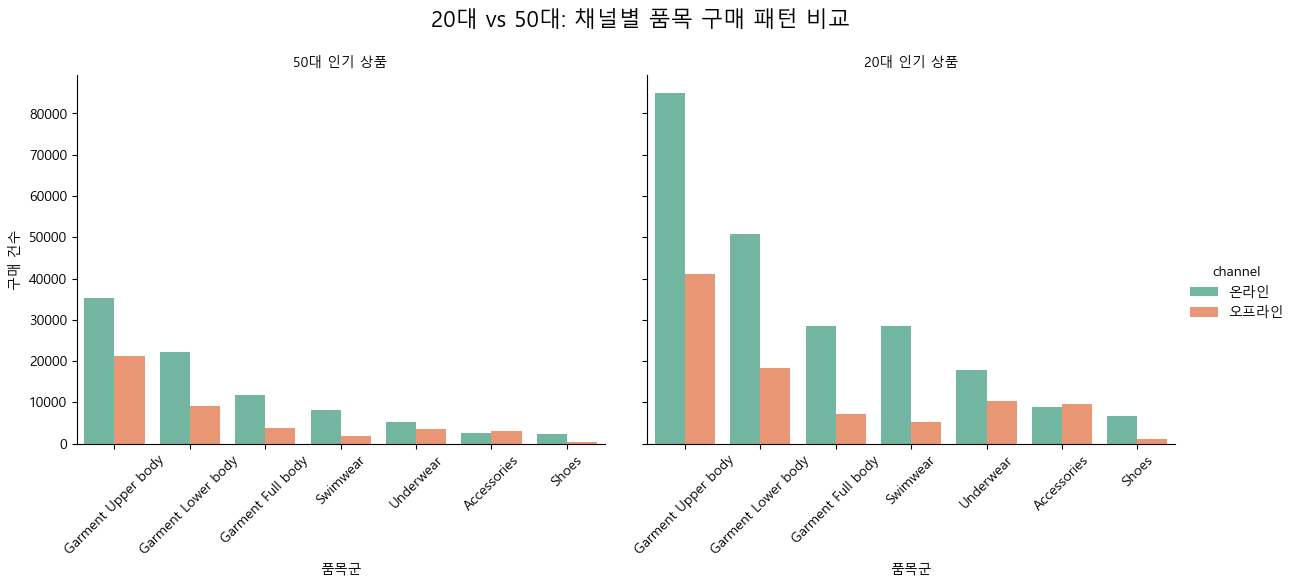

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 1. 시각화 대상 데이터 준비 (20대와 50대만 추출)
df_target = df_final[df_final['age_segment'].isin(['20대', '50대'])]

# 2. 그래프 그리기 (FacetGrid)
# 20대와 50대를 옆으로 나란히 배치하여 비교
g = sns.catplot(
    data=df_target, 
    x='product_group_name', 
    hue='channel', 
    col='age_segment', 
    kind='count',
    height=5, aspect=1.2,
    palette='Set2',
    order=df_target['product_group_name'].value_counts().head(7).index #상위 7개 품목만
)

# 3. 가독성을 위한 설정
g.set_xticklabels(rotation=45)
g.set_axis_labels("품목군", "구매 건수")
g.set_titles("{col_name} 인기 상품")
plt.subplots_adjust(top=0.85)   #치솟지마시오
g.fig.suptitle('20대 vs 50대: 채널별 품목 구매 패턴 비교', fontsize=16)

plt.show()

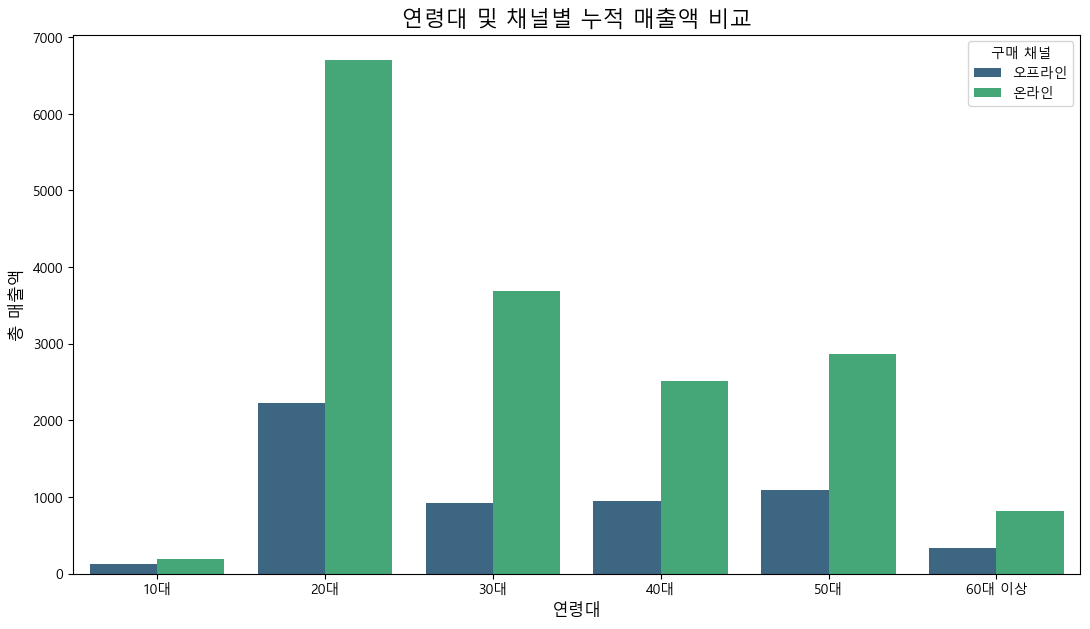

In [19]:
### 나이, 채널, 매출 관계 분석

#매출 준비
df_sales = df_final.groupby(['age_segment', 'channel'])['price'].sum().reset_index()

plt.figure(figsize=(13, 7))
sns.barplot(
    data=df_sales, 
    x='age_segment', 
    y='price', 
    hue='channel',
    palette='viridis',
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상']
)

plt.title('연령대 및 채널별 누적 매출액 비교', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('총 매출액', fontsize=12)
plt.legend(title='구매 채널', loc='upper right')

plt.show()


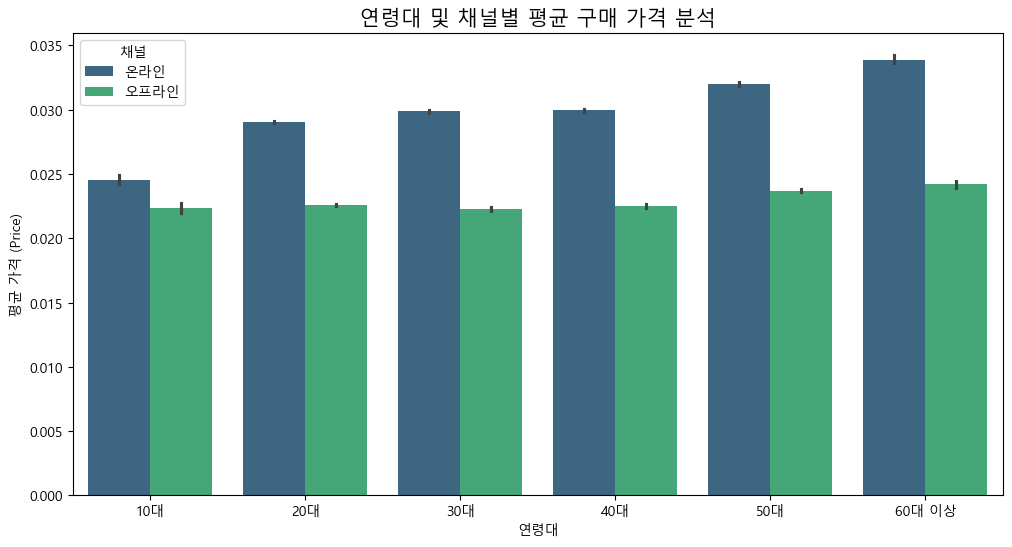

In [20]:
## 연령대 별 평균 가격은?

plt.figure(figsize=(12, 6))

sns.barplot(
    data=df_final, 
    x='age_segment', 
    y='price', 
    hue='channel',
    palette='viridis',
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상'] # 연령대 순서 고정
)

plt.title('연령대 및 채널별 평균 구매 가격 분석', fontsize=15)
plt.xlabel('연령대')
plt.ylabel('평균 가격 (Price)')
plt.legend(title='채널')

plt.show()

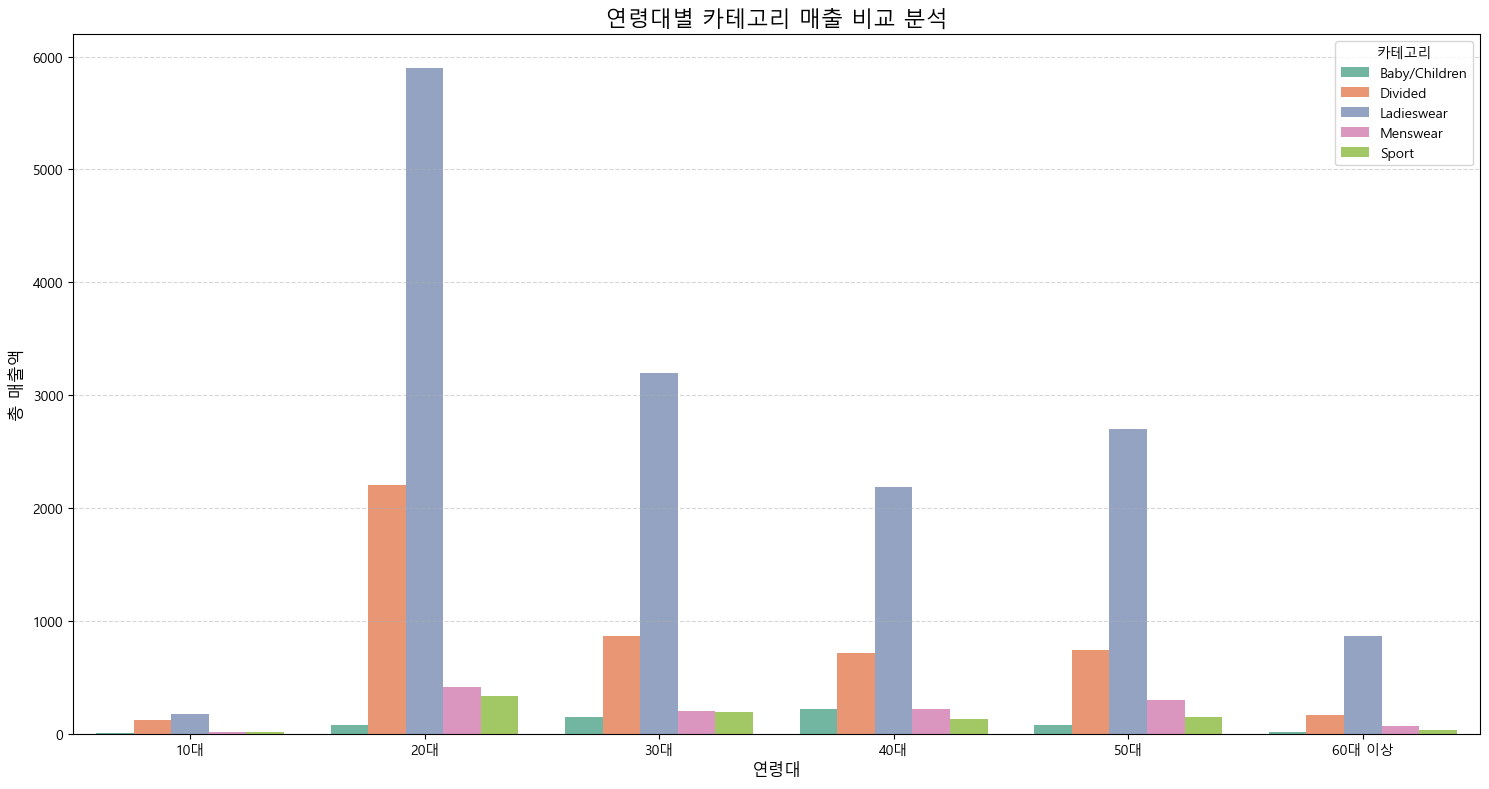

In [21]:
### 카테고리까지 같이 보면? 

## 연령대 + 카테고리의 매출액 합계 구하기
df_category_sales = df_final.groupby(['age_segment', 'category_main'])['price'].sum().reset_index()

plt.figure(figsize=(15, 8))
sns.barplot(
    data=df_category_sales,
    x='age_segment',
    y='price',
    hue='category_main',
    palette='Set2',
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상']
)
plt.title('연령대별 카테고리 매출 비교 분석', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('총 매출액', fontsize=12)
plt.legend(title='카테고리')
plt.grid(axis='y', linestyle='--', alpha=0.5)   #bbox_to_anchor=(1.05, 1), loc='upper left'로 표 바깥에 붙여서 가독성 높여도 OK

plt.tight_layout()
plt.show()

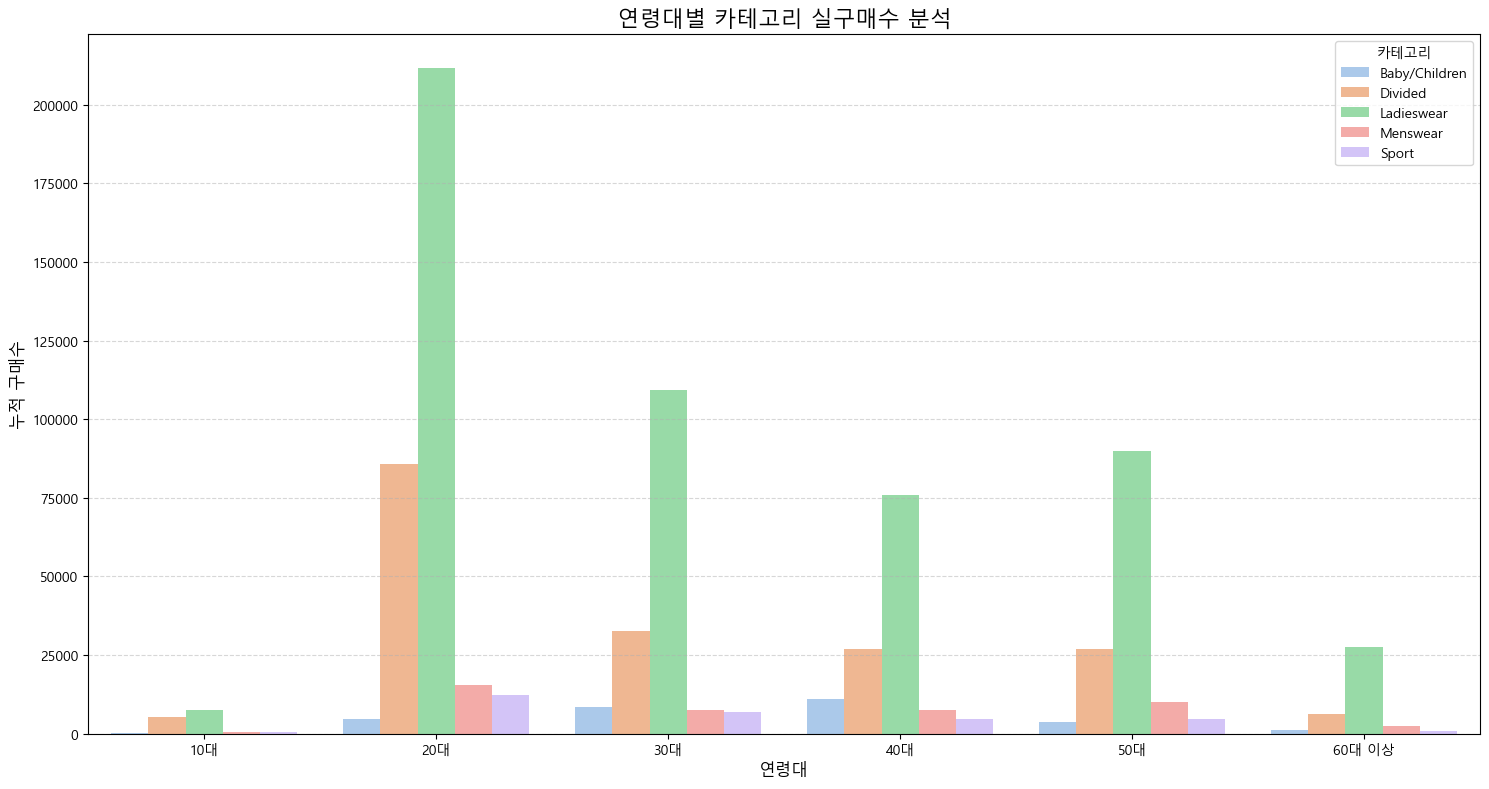

In [22]:
### 오... 아동복이 적네 그럼 가성비로 구매하는 것일 수도 있겠다 거래량으로 한번 보자

# 연령대, 카테고리를 거래량(구매 건수) 계산
df_category_counts = df_final.groupby(['age_segment', 'category_main']).size().reset_index(name='transaction_count')

plt.figure(figsize=(15, 8))
sns.barplot(
    data=df_category_counts,
    x='age_segment',
    y='transaction_count',
    hue='category_main',
    palette='pastel',
    order=['10대', '20대', '30대', '40대', '50대', '60대 이상']
)
plt.title('연령대별 카테고리 실구매수 분석', fontsize=16)
plt.xlabel('연령대', fontsize=12)
plt.ylabel('누적 구매수', fontsize=12)
plt.legend(title='카테고리')
plt.grid(axis='y', linestyle='--', alpha=0.5)   #비교를 위해 범례 붙여요우

plt.tight_layout()
plt.show()

### 왜 지난 번 카테고리 구매 비율과 다를까? 
* 아동복이 2위였던 이유 (추측):
    * 아동복은 개월수, 년별로 막 개수가 엄청 많으니까 구매가 많다고 생각할 수도 있겠다
    * 그럼 실구매횟수로 카테고리 파이차트 한번 다시 만들어보면 좋을듯


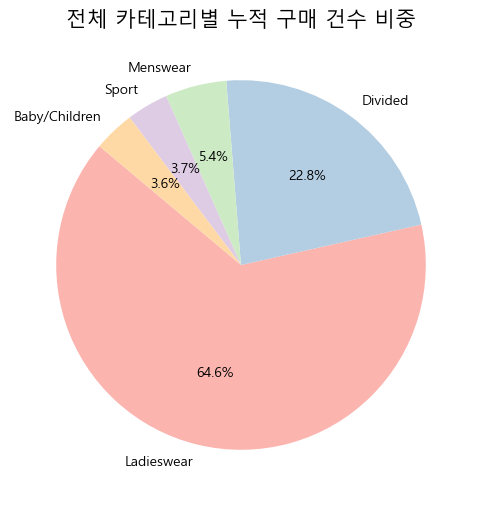

category_main
Ladieswear       672139
Divided          236753
Menswear          55812
Sport             38008
Baby/Children     37389
Name: count, dtype: int64


In [23]:
# 카테고리 거래 건수
category_counts = df_final['category_main'].value_counts()

plt.figure(figsize=(6, 6))
plt.pie(
    category_counts, 
    labels=category_counts.index, 
    autopct='%1.1f%%', # 소수점 첫째 자리까지 퍼센트 표시
    startangle=140, 
    colors=plt.cm.Pastel1.colors
)

plt.title('전체 카테고리별 누적 구매 건수 비중', fontsize=15)
plt.show()

#실제 거래 건수
print(category_counts)

* 와;; 꼴등이야

### 이런 오류가 왜 발생할까?
`df_art_cleaned['index_group_name'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))`

`category_counts = df_final['category_main'].value_counts()`
* value_counts 때문에? ... index_group_name으로 컬럼 선택해서 봤었는데 그럼 추측대로 컬럼 별 상품 수가 너무 많아서 아동복이 저렇게 관측될 수도 있겠다...
* 아니 근데 그렇다고 하더라도 2위에서 꼴등까지 돼?...아니.,.그래? 그래요? 이게맞아?


### 공유 내용
어... 연령대 별 카테고리 비중 시각화하다가 오해가 생길 수 있는 내용을 발견해서 공유드립니다 어제 저희가 EDA 시각화했던 articles 카테고리 비율 파이차트랑 오늘 다시 전체 카테고리 별 구매 건수 파이차트를 비교해보니까 '아동복'에 대한 오류가 있더라구요

`df_art_cleaned['index_group_name'].value_counts().plot.pie(autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))`

-> index_group_name으로 컬럼 선택해서 value_counts로 상품 수 확인. 단순히 '상품 수'가 많아서 아동복의 비율이 높게 나온..? 것 같습니다 (아마도......)-> ai튜터에게 물어보니까 아동복은 몇개월, 2세, 4세 엄청 여러 개로 나눠져있어서 '상품의 개수'가 많아서 2위를 차지할 수 있었던 게 아니냐고 하더라구요 참고해주세요!category_counts = df_final['category_main'].value_counts()-> 이건 카테고리 거래 건수라서 실제로 거래가 이루어진 비율이라서 저희 H&M의 카테고리 인기 비중은 두번째 차트로 생각해주시면 좋을 것 같습니다.... MZ 라인이 꽤 많이 나오더라구요 다양한 연령대도 포함해서 꾸준히 2위하는 카테고리라서(대본 짤 때는 MZ라인이 맞는지 조사가 필요할 수도 있을 것 같습니다! 국내에는 없는 카테고리라 정보를 찾기가 어렵네요 ㅜㅜ) 혹시 저희 최종 전략 짤 때 참고하면 좋을 것 같아서 공유드립니다두 줄 요약 :진짜 효자 품목 : 여성복, divided가짜 효자 품목... : 아동복(장기 재고 많음. 가짓수가 많은 것에 비해 판매율 저조)생각해보니 아동복은 트랜드를 많이 안 타니까 장기재고가 많아도 괜찮은 품목같기도 하네요! 나중에 발표 시 한두줄 덧붙이면 좋을 것 같습니다! 세번째 사진은 실제 거래 횟수입니다! (=인기품목)

In [24]:
#!python -m jupyter nbconvert --to markdown "02_marge.ipynb"